In [1]:
# ROM for 2D Building induced turbulence (turbulent kinetic energy)
    # with POD coefficient parameterized for wind direction.
    
# Details of database : 
    # Six Wind directions : [90,22.5,360,200,180,270] #[E,NNE,N,SSW,S,W]
    #"2D plane mesh from 3D data"
    # Polygonal Mesh - Cells : 433086 , Points : 234314
    # TKE values range from 0 - 0.6 m2/s2.    
    
#For Flow reconstruction (see at end): Input needed : (a) wind direction in degrees, (2) Load POD modes,(c) Load Mean TKE, and (d) Load trained RBF interpolators to compute POD coefficient for given wind direction.

# ROM: TKE field reconstruction for 433086 cells for a wind direction (without loading times) should take less than 0.1 s.

# Load libraries 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf #for regression.

#import pyvista
import pyvista as vtki
import numpy as np
import os
import pandas as pd
%config Completer.use_jedi = False


import vtk
from vtk.numpy_interface import dataset_adapter
from vtk.numpy_interface import algorithms as algs

import sys
from os.path import isdir, isfile, join
from os.path import expanduser
import numpy as np
import re

import json
import pickle


import numpy as np
import random
import time as timer
import pickle

import matplotlib.pyplot as plt
import os, sys

from pyvistaqt import BackgroundPlotter
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

#import tensorflow as tf

#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import Dense, Input, concatenate
#from tensorflow.keras.layers import LSTM, Flatten, Reshape, Conv2D, Conv2DTranspose, Dropout

#from tensorflow.keras import backend as K
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.model_selection import train_test_split


/usr/lib/python3/dist-packages/ipykernel_launcher.py:10: UserWarning: Config option `use_jedi` not recognized by `IPCompleter`.
  # Remove the CWD from sys.path while we load stuff.


# Load Building CFD data and read/visualize using pyVista

In [3]:


#To generate snapshots for basis functions - run the following script in paraview 
#%run run_in_paraview_for_snapshotdataset

In [4]:
# tips for uniform grid
# https://discourse.vtk.org/t/creating-uniform-rectilinear-slice-of-3d-data/1002/2

In [5]:
#Filenames to load the data 
fnyaw_0='/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings'
filenames=[fnyaw_0] 
print(filenames[0])

/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings


In [6]:
res=[]
for (root,dirs,files) in os.walk(fnyaw_0, topdown=True):
    for name in files:
        #print ((os.path.join(root, name)))
        #subs='U_zplane'
        #print(name)
        #break
        #res = [i for i in name if subs in os.path.join(root, name)]
        #print (root)
        #print (dirs)
        #print (files)
        #if name=='U_zplane.vtk':
        res.append(os.path.join(root, name))              
        

In [7]:
res.sort()

In [8]:
res

['/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/E_7000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/NNE_7000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/N_3000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/SSW_7000_slide.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/S_7000_slice.vtk',
 '/media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/W_3000_slice.vtk']

In [9]:
 def generate_data(res,charname='k'):       
        Ut11=[]
        for filename in res: 
            #loop on files 
            Utemp1=[]       
            
            grid = vtki.PolyData(filename) #Read data in a file
               
            print('creating TRAINING data for filename',filename)
            #print(charname,type(charname),type('k'))
            
            Utemp1=grid[charname].ravel(order='F') #Flattened array 1D for TKE field using ravel
        
            Ut11.append(Utemp1)
   
        #LOOP OVER TIME STEP ENDS HERE. 
        # At the end of loop - We have a "list of arrays". The length of list= total number of arrays = "num_times", 
        # and each of these array is of size num_grid_size. 
    
        #CREATE 2D ARRAY FROM ABOVE LIST OF ARRAYS.
        #Below we use numpy stack, to combine list of arrays 
        #in such a way that each array in the list is added as new feature (as new column).
        
        #print('lenUt11',len(Ut11))
        
        U1=np.stack(Ut11,axis=1)   #it joins arrays from list of arrays.Dimensions along column a new axis.
        
        return U1,grid

# Load all building data

In [10]:
k1,grid=generate_data(res,charname='k')

creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/E_7000_slice.vtk
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/NNE_7000_slice.vtk
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/N_3000_slice.vtk
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/SSW_7000_slide.vtk
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/S_7000_slice.vtk
creating TRAINING data for filename /media/mandart/D/NorthWind-FME/Junmiao-database/270yaw/buildings/W_3000_slice.vtk


# Save building data

In [11]:
np.save('k_building_nigata.npy',k1)

In [12]:
k1.shape #num_spatial x num_times

(433086, 6)

In [13]:
k1.max()

0.653371

In [14]:
k1.min()

7.91944e-15

In [15]:
grid.array_names

['p', 'nut', 'k', 'omega', 'U', 'cellID', 'p', 'nut', 'k', 'omega', 'U']

In [16]:
type(grid)

pyvista.core.pointset.PolyData

# Define all POD functions

In [17]:
#POD functions

nd,ns = k1.shape
nr=np.min([10,ns])

def POD_svd(tdata,nr):
    
    nd,ns = tdata.shape #nd=grid, ns=wind direction (instead of time).
    
    
       
    #mean subtraction
    
    tm = np.mean(tdata) #tdata,axis=1, Use axis when 3D, and generating basis for each parameter.
    #um = np.mean(Au,axis=1)
    
    
    At = tdata - tm #.reshape([-1,1])
    
    
    print('At',At.shape)
    
    #singular value decomposition : https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html
    
    Ut, St, Vht = LA.svd(At, full_matrices=False)
    
   
    print(Ut.shape,St.shape,Vht.shape)
           
    Phit = Ut[:,:nr]  
    Lt = St**2
    
    #compute RIC (relative importance index)
    RICt = np.cumsum(Lt)/np.sum(Lt)*100
    
    
    return tm,Phit,Lt,RICt 

def PODproj_svd(u,Phi): #Projection
    a = np.dot(Phi.T,u)  # u = Phi * a if shape of a is [nr i.e num_modes,ns i.e num_winddirection]
    return a

def PODrec_svd(a,Phi): #Reconstruction    
    u = np.dot(Phi,a)    
    return u







###############################################################################
#POD Routines without mean
###############################################################################         
def POD(u,R): #Basis Construction
    n,ns = u.shape
    U,S,Vh = LA.svd(u, full_matrices=False)
    Phi = U[:,:R]
    L = S**2
    #compute RIC (relative inportance index)
    RIC = sum(L[:R])/sum(L)*100   
    
    return Phi,L,RIC

def PODproj(u,Phi): #Projection
    a = np.dot(u.T,Phi)  # u = Phi * a.T
    return a

def PODrec(a,Phi): #Reconstruction    
    u = np.dot(Phi,a.T)    
    return u


In [18]:
import numpy.linalg as LA

# Obtain POD basis functions for turbulent kinetic energy

In [19]:
tm,Phit,Lt,RICt=POD_svd(k1,nr) #mean tke, tke basis functions (modes) , magnitude (energy) , relative importance of modes. 

At (433086, 6)
(433086, 6) (6,) (6, 6)


# 

# Obtain POD true coefficients 
#### by projecting the data (without the mean) on the basis functions
##### for turbulent kinetic energy

In [20]:
k1_wo_mean = k1-tm

tcoeff = PODproj_svd(k1_wo_mean,Phit)

### TKE mean value below

In [21]:
tm

0.10376703

In [22]:
# create plots folder
fn="./Plots1"
if os.path.isdir(fn):
    print('Plots folder already exists')
else: 
    print('Creating plots folder')
    os.makedirs(fn)

Plots folder already exists


# Plot variance/energy captured by modes

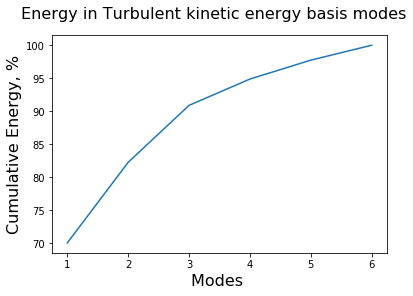

In [23]:
fig = plt.figure()
plt.plot(range(1,nr+1),np.cumsum(Lt)/sum(Lt)*100)
fig.suptitle('Energy in Turbulent kinetic energy basis modes', fontsize=16)
plt.xlabel('Modes ', fontsize=16)
plt.ylabel('Cumulative Energy, %', fontsize=16)
fig.savefig(fn+'/Cumulative_Energy_Velocity.png')
fig.savefig(fn+'/Cumulative_Energy_Velocity.pdf')

# Save all POD modes in VTK format for visualization in paraview

In [24]:
for i in range(nr): #nr , first 5 modes saved.
    grid.cell_data["tke_mode_"+str(i)]=Phit[:,i]
    

In [25]:
#Note: Pyvisa visualization not working now. So, visualize in paraview.
grid.cell_data

pyvista DataSetAttributes
Association     : CELL
Active Scalars  : tke_mode_5
Active Vectors  : None
Active Texture  : None
Active Normals  : None
Contains arrays :
    cellID                  int32    (433086,)
    p                       float32  (433086,)
    nut                     float32  (433086,)
    k                       float32  (433086,)
    omega                   float32  (433086,)
    U                       float32  (433086, 3)
    tke_mode_0              float32  (433086,)
    tke_mode_1              float32  (433086,)
    tke_mode_2              float32  (433086,)
    tke_mode_3              float32  (433086,)
    tke_mode_4              float32  (433086,)
    tke_mode_5              float32  (433086,)            SCALARS

In [26]:
grid


PolyData (0x7f52c4a0f4c8)
  N Cells:	433086
  N Points:	234314
  X Bounds:	-1.024e+00, 1.024e+00
  Y Bounds:	-1.024e+00, 1.024e+00
  Z Bounds:	1.000e-03, 1.000e-03
  N Arrays:	17

/home/mandart/.local/lib/python3.6/site-packages/pyvista/jupyter/notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(f'Failed to use notebook backend: \n\n{e}\n\n'


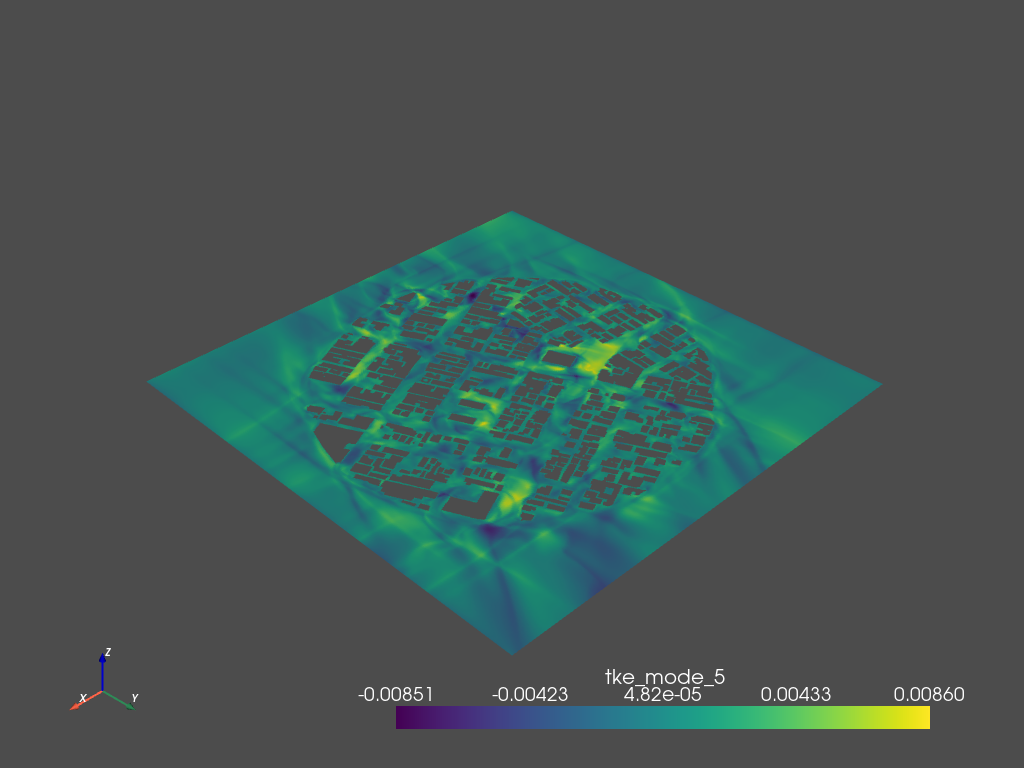

In [27]:
grid.plot('k')

#Important basis modes saved in new VTK files
grid.save('Basisadded.vtk')

In [28]:
nr,ns

(6, 6)

# Save POD data and VTK files

In [29]:
# Save POD data and VTK files

folder = 'data_POD' #str(nx) + '_' + str(ny)       

if not os.path.exists('./Results/'+folder):
    os.makedirs('./Results/'+folder)

filename = './Results/'+folder+'/POD_data.npz'
np.savez(filename, tmean=tm, tbasis=Phit,tcoeff=tcoeff,teigenvalues=Lt,tric=RICt)
    

In [30]:
Phit.shape

(433086, 6)

In [31]:
tcoeff.shape

(6, 6)

# Interpolate True Coefficient as function of wind direction using Radial basis function

In [32]:
input_feature=[90,22.5,360,200,180,270] #[E,NNE,N,SSW,S,W]

In [33]:
# Wind direction is a cyclic feature . So convert it into a form required for  input feature into form required.


In [34]:
input_feature

[90, 22.5, 360, 200, 180, 270]

### Convert cyclic features

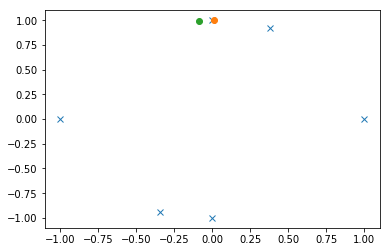

In [35]:
data=np.array(input_feature)
max_value=360
xsin1=np.sin(2 * np.pi * data / max_value)
xcos1=np.cos(2 * np.pi * data / max_value)
plt.plot(xsin1,xcos1,'x')
plt.plot(np.sin(2 * np.pi *(0.5/360)),np.cos(2 * np.pi *0.5/360),'o',label='0.5')
plt.plot(np.sin(2 * np.pi *(355/360)),np.cos(2 * np.pi *355/360),'o',label='355')
    

res

North (N): 0° = 360°
East (E): 90°
South (S): 180°
West (W): 270°
Intercardinal directions
The intercardinal (intermediate, or, historically, ordinal[2]) directions are the four intermediate compass directions located halfway between each pair of cardinal directions.

Northeast (NE), 45°, halfway between north and east, is the opposite of southwest.
Southeast (SE), 135°, halfway between south and east, is the opposite of northwest.
Southwest (SW), 225°, halfway between south and west, is the opposite of northeast.
Northwest (NW), 315°, halfway between north and west, is the opposite of southeast.


In [36]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

plt.rc('font', **font)

# Plot true coefficient as function of wind directions and save the figures

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


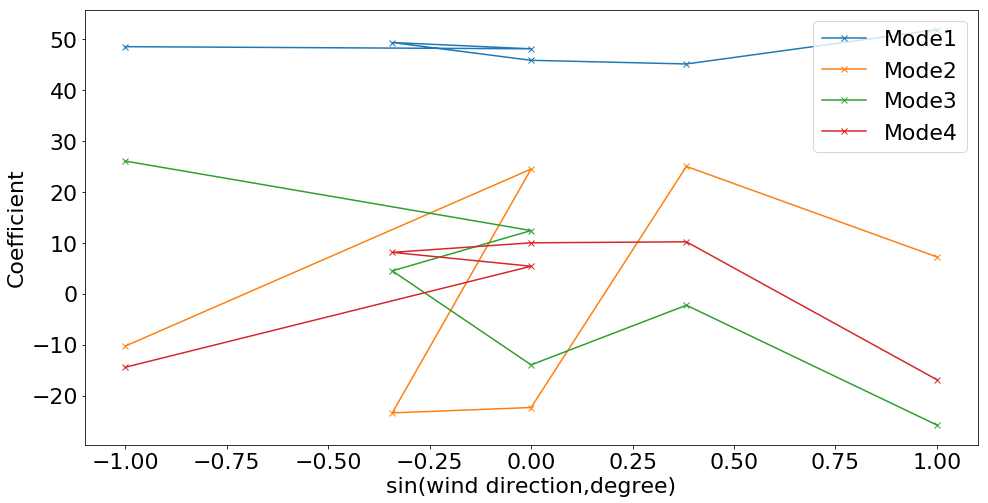

In [37]:
#tcoeff #modes x wind_direction
plt.figure(figsize=(16,8))
for i in range(4): #6
    plt.plot(xsin1,tcoeff[i,:],'x-',label='Mode'+str(i+1))
plt.xlabel('sin(wind direction,degree)')
plt.ylabel('Coefficient')
plt.legend()   

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


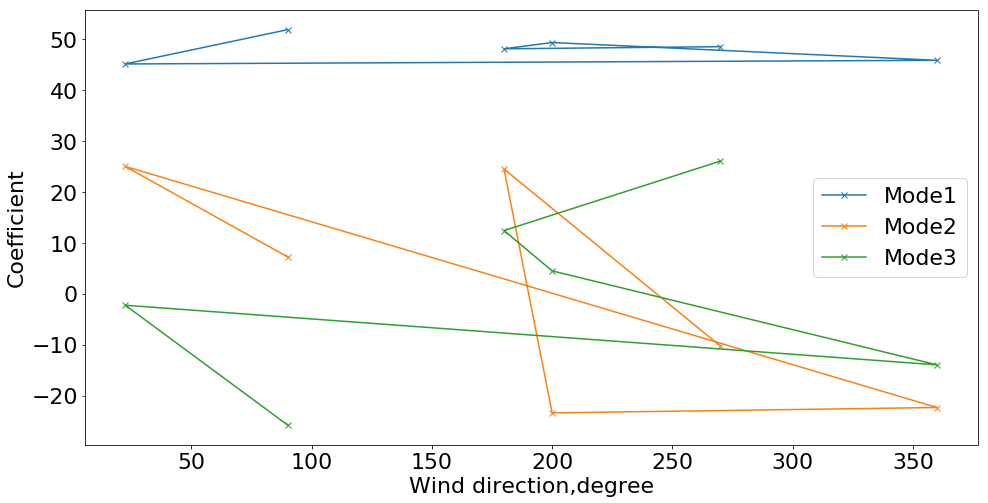

In [38]:
#tcoeff #modes x wind_direction
plt.figure(figsize=(16,8))
for i in range(3): #6
    plt.plot(data,tcoeff[i,:],'x-',label='Mode'+str(i+1))
plt.xlabel('Wind direction,degree')
plt.ylabel('Coefficient')
plt.legend()  
plt.savefig('./Results/coeff_vs_wd.png')
plt.savefig('./Results/coeff_vs_wd.pdf')

In [39]:
nr

6

# Create nr number of Rbf interpolator models for each of the nr modes.
    ## For a given wind direction, the RBf models are used to compute the Coefficient for each basis. 

In [40]:
import numpy as np
from scipy.interpolate import Rbf
import pickle


# Create Rbf interpolators for each mode. Then 
interpolators = []
for i in range(nr):
    rbf = Rbf(xsin1,xcos1,tcoeff[i,:],function='multiquadric') 
    interpolators.append(rbf)

# Save the Rbf interpolators to a file
with open('./Results/'+folder+'/rbf_interpolators.pkl', 'wb') as file:
    pickle.dump(interpolators, file)

# Load the Rbf interpolators from a file
with open('./Results/'+folder+'/rbf_interpolators.pkl', 'rb') as file:
    loaded_interpolators = pickle.load(file)

# Interpolate using the loaded interpolators (for demonstration)

predicted_values = []
for i, rbf in enumerate(loaded_interpolators):
    predicted_values.append(rbf(xsin1,xcos1))

# The 'predicted_values' list now contains the interpolated values using the loaded interpolators.


np.array(predicted_values)

# Plot temporal coefficients : check RBF interpolation

import inspect
print(inspect.getargspec(plt.legend))  

/usr/lib/python3/dist-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


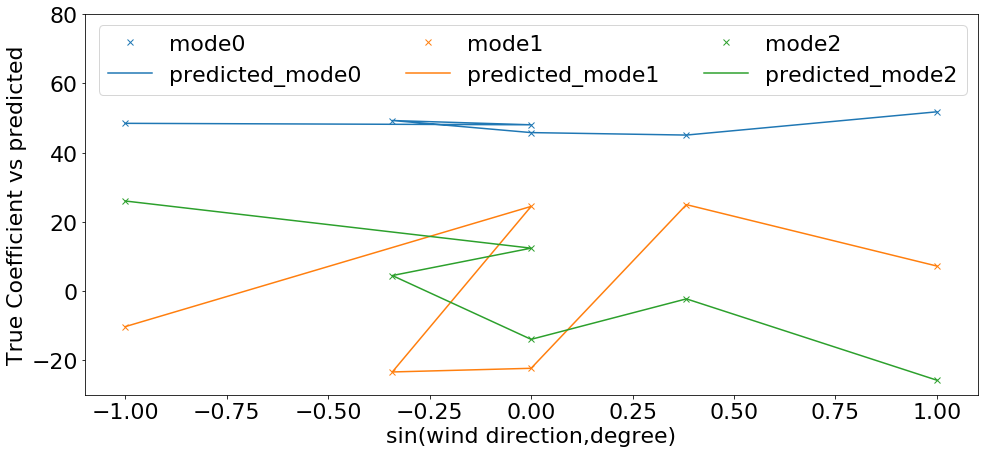

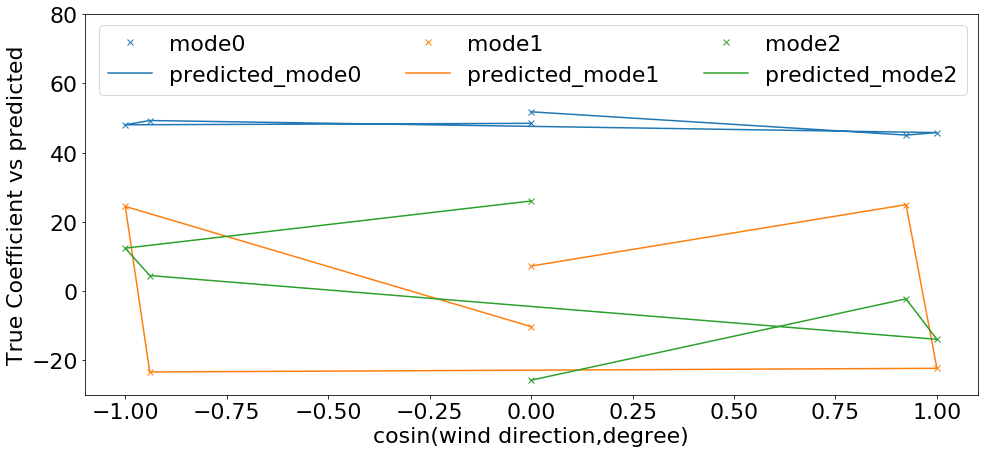

In [42]:
plt.figure(figsize=(16,7))
for i in range(3):
    plt.plot(xsin1,tcoeff[i,:],'x',label='mode'+str(i))
    plt.plot(xsin1,np.array(predicted_values)[i,:],color=plt.gca().lines[-1].get_color(),label='predicted_mode'+str(i))
plt.xlabel('sin(wind direction,degree)')
plt.ylabel('True Coefficient vs predicted')
plt.ylim((-30,80))
plt.legend(loc='upper right',ncol=3)

plt.figure(figsize=(16,7))
for i in range(3):
    plt.plot(xcos1,tcoeff[i,:],'x',label='mode'+str(i))
    plt.plot(xcos1,np.array(predicted_values)[i,:],label='predicted_mode'+str(i),color=plt.gca().lines[-1].get_color())
plt.xlabel('cosin(wind direction,degree)')
plt.ylabel('True Coefficient vs predicted')
plt.ylim((-30,80))
plt.legend(loc='upper right',ncol=3)

# Reconstruct flow field for a given wind direction

In [43]:
import time
start = time.process_time()
# your code here    

# Assume a wind direction 
wind_dir=80 #in degrees

folder = 'data_POD'

#Obtain coefficient for this wind direction
#------------------------------------------------------------------


# Load the Rbf interpolators from a file
with open('./Results/'+folder+'/rbf_interpolators.pkl', 'rb') as file:
    loaded_interpolators = pickle.load(file)

    
# Interpolate using the loaded interpolators (for demonstration)
predicted_coef = []
max_value=360
xsin_winddir=np.sin(2 * np.pi * wind_dir / max_value)
xcos_winddir=np.cos(2 * np.pi * wind_dir / max_value)
for i, rbf1 in enumerate(loaded_interpolators):
    predicted_coef.append(rbf1(xsin_winddir,xcos_winddir))
    print('Coeff for mode', i+1 , 'is ', rbf1(xsin_winddir,xcos_winddir))

#Obtain basis functions
#----------------------------------------------------------------------------------------------------

#Load saved basis functions (modes) and mean turbulent kinetic energy

filename = './Results/'+folder+'/POD_data.npz' #A NpzFile is a dictionary-like object.Query with the .files attribute) and for the arrays themselves.

PODdata=np.load(filename)

Phit=PODdata['tbasis']
tke_mean=PODdata['tmean']


#Reconstruct flow field from the basis modes, the mean and the computed coefficients
#----------------------------------------------------------------------------------------------------
tke_at_wind_direction=np.dot(Phit,np.array(predicted_coef))+tke_mean

#Visualize reconstructed flow field.
#----------------------------------------------------------------------------------------------------
grid.cell_data["RECON_tke_at_WD_"+str(wind_dir)]=tke_at_wind_direction


#Print time taken
print(time.process_time() - start)

Coeff for mode 1 is  51.080309430976016
Coeff for mode 2 is  11.632695307416565
Coeff for mode 3 is  -23.291720223393884
Coeff for mode 4 is  -14.187790143463664
Coeff for mode 5 is  8.424499176703367
Coeff for mode 6 is  2.2233383084322558
0.4959619169999989


In [44]:
PODdata.files

['tmean', 'tbasis', 'tcoeff', 'teigenvalues', 'tric']

# SAVE VTK files with POD modes and Reconstructions for visualization

In [45]:
grid.save('./Results/recon_added.vtk')

In [46]:
tke_at_wind_direction.shape

(433086,)

# ENDS HERE

#  ---------------------------------------------------------------------------------------

#  ----------------------------------------------------------------------------------

##### Not needed below: Testing time needed if one does not load and save the modes, but just reconstructs. About 0.09 s.